# Wikipedia DeepWalk graph embedding

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

## Load Data

Get data from:
https://densitydesign.github.io/strumentalia-seealsology/  

Use the following links as start:  
https://en.wikipedia.org/wiki/Machine_learning  
https://en.wikipedia.org/wiki/Deep_learning  
https://en.wikipedia.org/wiki/Computer_vision  
https://en.wikipedia.org/wiki/Neural_network  
https://en.wikipedia.org/wiki/Graph_neural_network  

set distance = 4

In [4]:
df = pd.read_csv("seealsology-data.tsv", sep = "\t")

In [5]:
df.head()

,source,target,depth
0,computer vision,computational imaging,1
1,computer vision,computational photography,1
2,computer vision,computer audition,1
3,computer vision,egocentric vision,1
4,computer vision,machine vision glossary,1


In [6]:
df.shape

(14001, 3)

## Build graph

In [7]:
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())

In [8]:
len(G)

8715

## Generate Random Walk Sequence

In [15]:
def get_randomwalk(node, path_length):
    '''
    Input: start node and path length.
    
    Output: Random Walk Sequence.
    '''
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))
        if len(temp) == 0:
            break
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [16]:
all_nodes = list(G.nodes())

In [20]:
get_randomwalk('machine learning', 5)

['machine learning',
 'hyper-heuristics',
 'genetic programming',
 'fitness approximation',
 'evolutionary computation']

In [21]:
gamma = 10 # The number of sequences for each node as the start node
walk_length = 5 # Maximum length of the random walk sequence

In [22]:
random_walks = []

for n in tqdm(all_nodes):
    for i in range(gamma):
        random_walks.append(get_randomwalk(n, walk_length))

100%|███████████████████████████████████████████████████████████████████████████| 8715/8715 [00:00<00:00, 15260.08it/s]


In [23]:
len(random_walks)

87150

In [26]:
random_walks[0]

['computer vision', 'egocentric vision']

## Train Word2Vec Model

In [27]:
from gensim.models import Word2Vec

In [28]:
model = Word2Vec(vector_size=256,
                 window=4,
                 sg=1,
                 hs=0,
                 negative=10,
                 alpha=0.03,
                 min_alpha=0.0007,
                 seed=14
                 )

In [29]:
model.build_vocab(random_walks, progress_per=2)

In [30]:
model.train(random_walks, total_examples=model.corpus_count, epochs=50, report_delay=1)

(16863992, 16885000)

## Analysis

In [31]:
model.wv.get_vector('machine learning').shape

(256,)

In [32]:
model.wv.get_vector('machine learning')

array([-0.24272004, -0.49778563,  0.15914208,  0.52236086,  0.25355896,
       -0.27888027,  0.06649257,  0.06272876, -0.24019437, -0.70235586,
       -0.55193317, -0.11842632,  0.40731058, -0.43175617, -0.31797117,
       -0.34538642,  0.08403596, -0.4524188 , -0.32464886, -0.07775015,
       -0.38872313, -0.09616319, -0.309269  ,  0.5004021 ,  0.44245517,
        0.15770769, -0.70168734, -1.3879131 ,  0.05291313, -0.98159736,
       -0.81096643,  0.36289227,  0.41706863,  0.08715151, -0.23590918,
        0.47921455,  0.9200875 , -0.39172283, -0.06862745, -0.23257084,
       -0.02592673, -0.06691615, -0.20616513,  0.29643095,  0.59186417,
       -0.3739298 , -0.33841228, -0.4181223 ,  0.30840233, -0.00599673,
       -0.2263822 ,  0.5998695 , -0.1773208 , -0.8362785 ,  0.11597048,
       -0.16468814,  0.5017298 , -0.38209656,  0.13117166, -0.24784654,
       -0.88429785,  0.6721009 , -0.01348084,  0.30968276,  0.6319055 ,
        0.1702511 , -0.92532843, -0.19044635, -0.10405825,  0.78

In [33]:
# similar words
model.wv.similar_by_word('machine learning')

[('information governance', 0.6008594632148743),
 ('forensic search', 0.5969723463058472),
 ('telecommunications data retention', 0.5764392614364624),
 ('electronically stored information (federal rules of civil procedure)',
  0.5667141675949097),
 ('memetic algorithms', 0.5598222017288208),
 ('entropic value at risk', 0.5598012804985046),
 ('local search (optimization)', 0.5567167401313782),
 ('discovery (law)', 0.5496249794960022),
 ('reactive search', 0.5476006865501404),
 ('semi-differentiability', 0.5433115363121033)]

## PCA dimensionality reduction visualization

In [34]:
X = model.wv.vectors

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(X)

In [37]:
embed_2d.shape

(8715, 2)

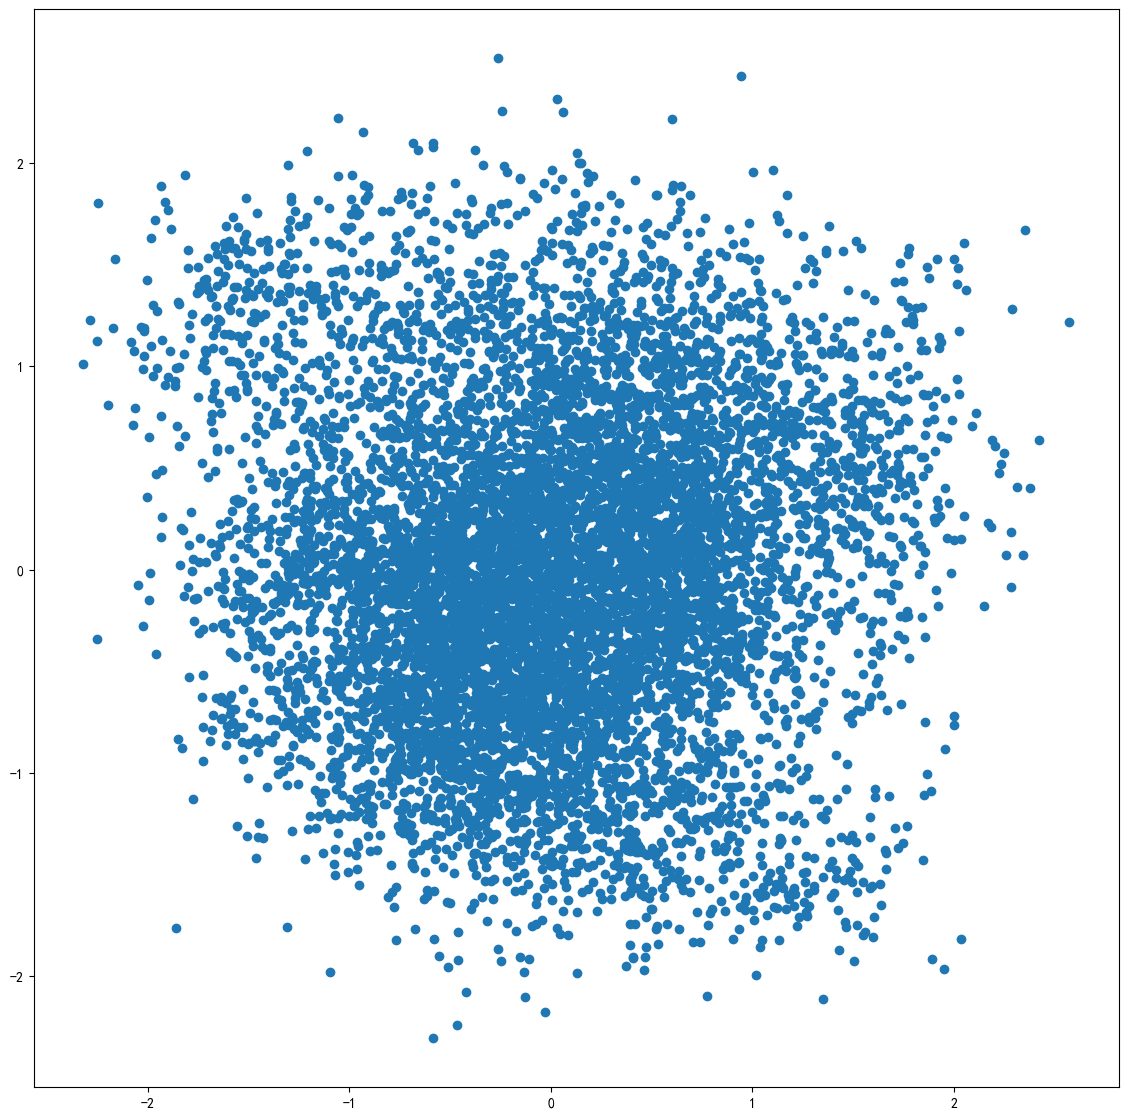

In [38]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

## Visualization of a single embedding

In [39]:
term = 'machine learning'
term_256d = model.wv[term].reshape(1, -1)

In [40]:
term_2d = pca.transform(term_256d)

In [41]:
term_2d

array([[1.2851987, 1.5297223]], dtype=float32)

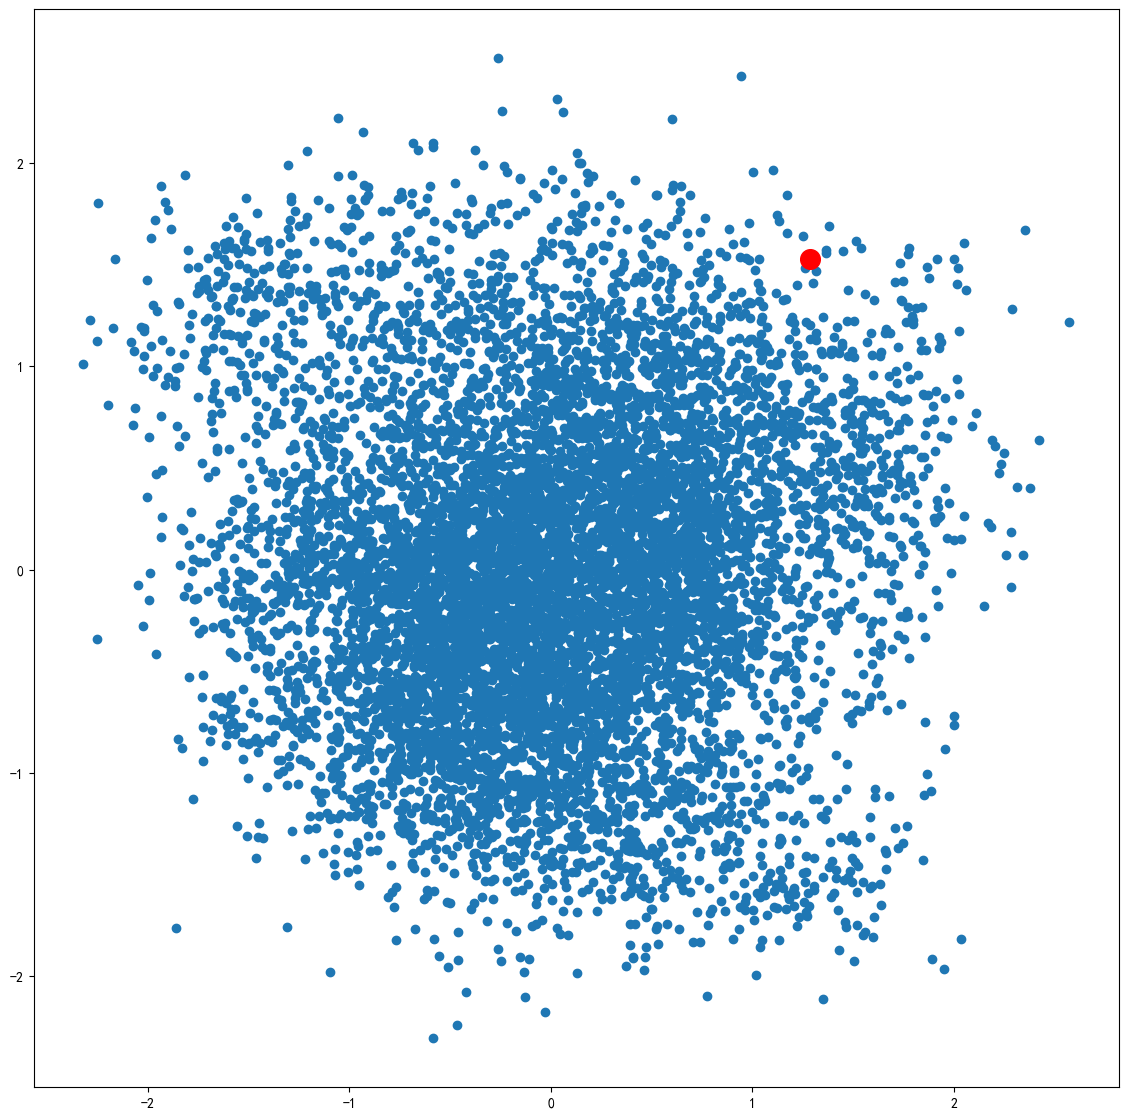

In [42]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.scatter(term_2d[:, 0], term_2d[:, 1], c='r', s=200)
plt.show()

## Visualization of a list of embeddings which have top k PageRank

In [43]:
pagerank = nx.pagerank(G)
node_importance = sorted(pagerank.items(), key=lambda x:x[1], reverse=True)

In [44]:
n = 30
terms_chosen = []
for each in node_importance[:n]:
    terms_chosen.append(each[0])

In [46]:
terms_chosen

['mathematical finance',
 'graph theory',
 'causality',
 'population genetics',
 'information theory',
 'chaos theory',
 'philosophy of thermal and statistical physics',
 'freedom of information',
 'operations research',
 'cognitive dissonance',
 'data mining',
 'collective intelligence',
 'reverse engineering',
 'low-density parity-check code',
 'simulated reality',
 'industrial ecology',
 'web mining',
 'scientism',
 'perennial philosophy',
 'proteomics',
 'solipsism',
 'mass surveillance',
 'fuzzy concept',
 'information',
 'evolutionary psychology',
 'the real',
 'network science',
 'data integration',
 'digital divide',
 'analytics']

In [47]:
term2index = model.wv.key_to_index

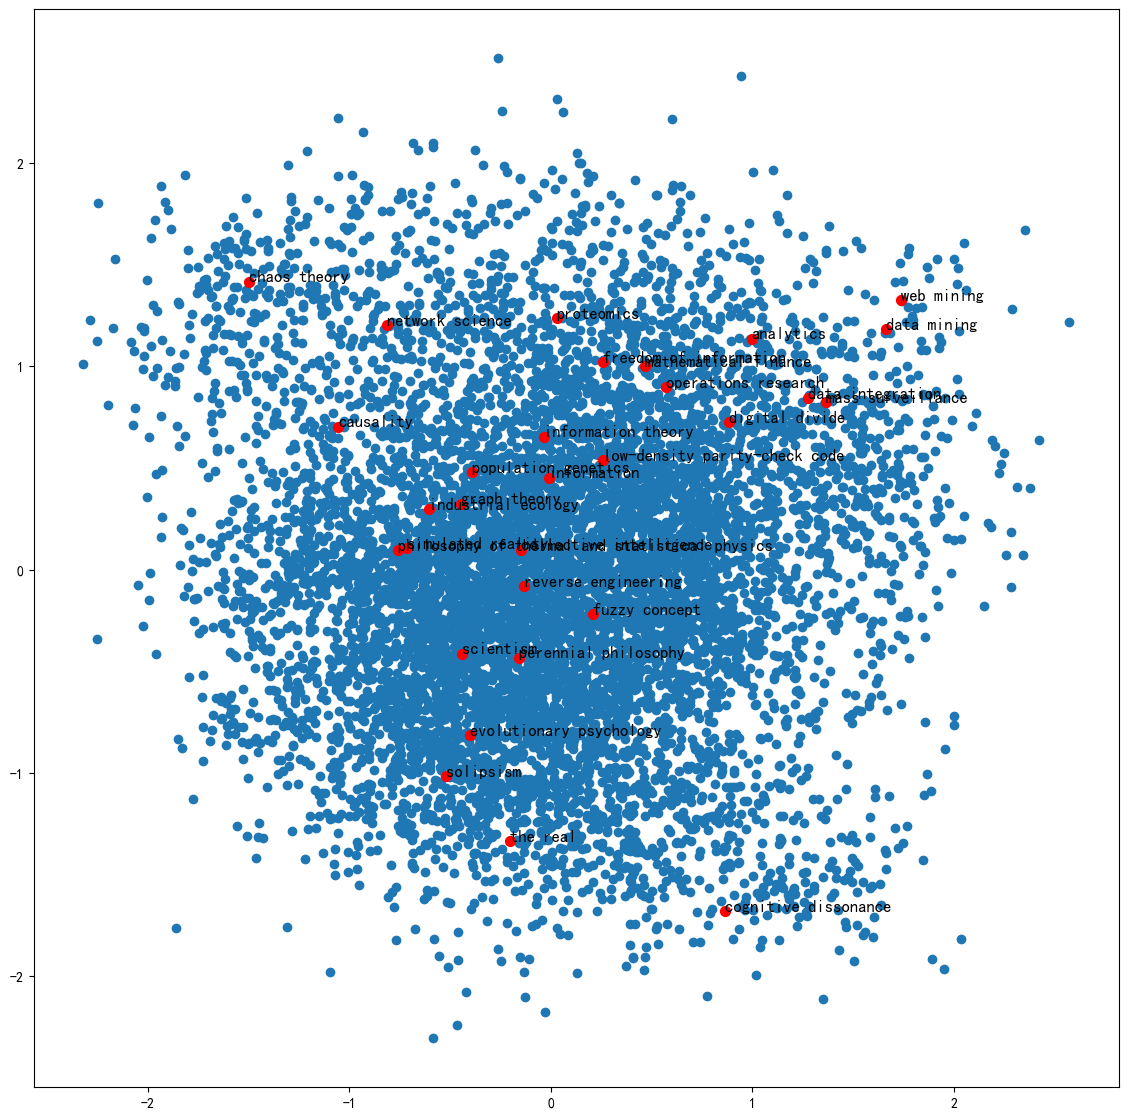

In [48]:
plt.figure(figsize=(14, 14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])

for item in terms_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx, 0], embed_2d[idx, 1], c='r', s=50)
    plt.annotate(item, xy=(embed_2d[idx, 0], embed_2d[idx, 1]), c='k', fontsize=12)
plt.show()

## TSNE visualization

In [49]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
embed_2d = tsne.fit_transform(X)

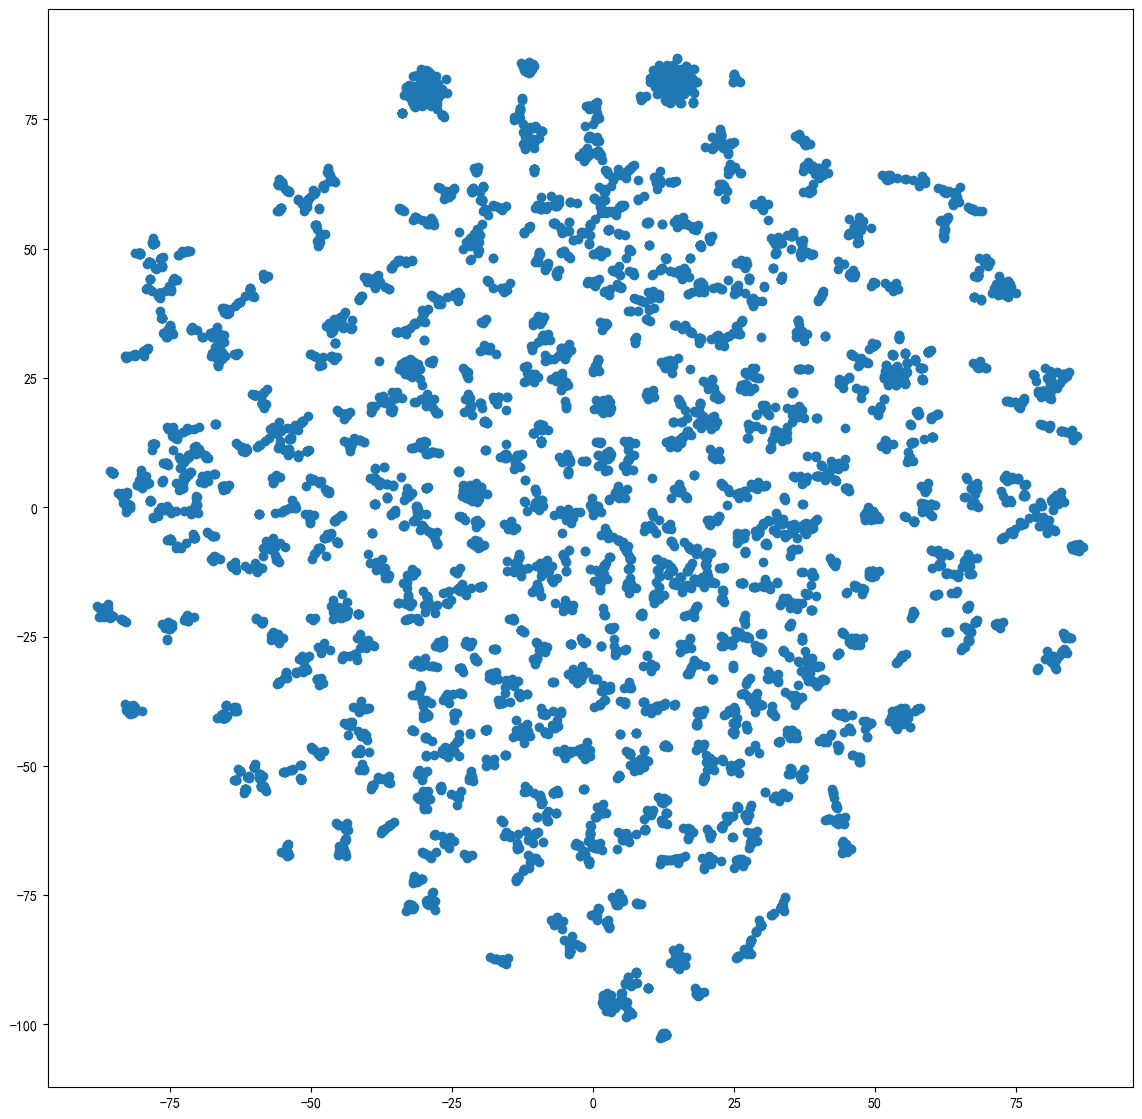

In [50]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

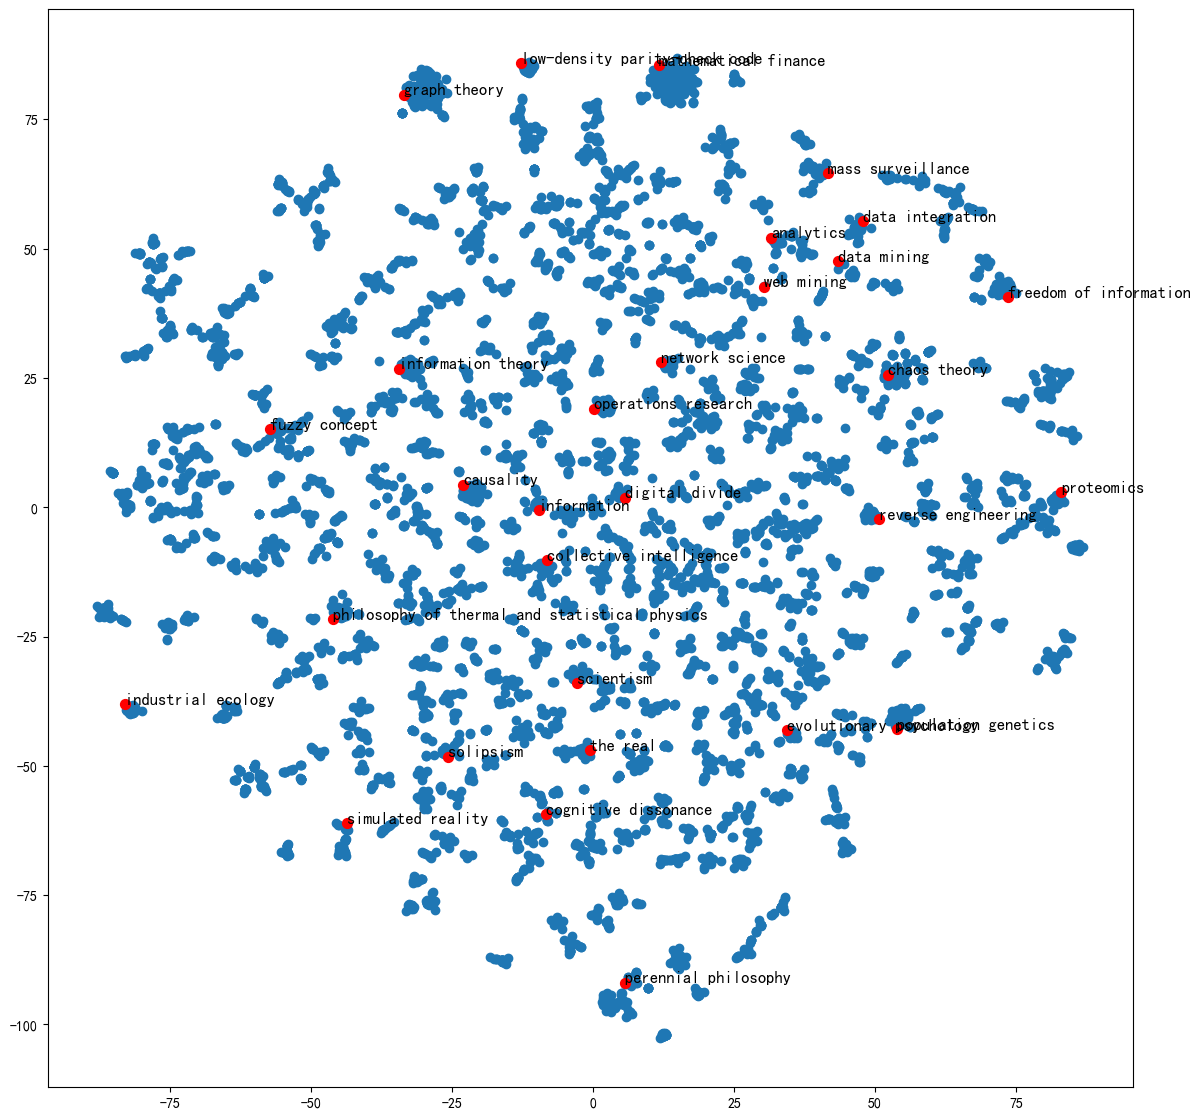

In [51]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])

for item in terms_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx, 0], embed_2d[idx, 1], c='r', s=50)
    plt.annotate(item, xy=(embed_2d[idx, 0], embed_2d[idx, 1]), c='k', fontsize=12)
plt.show()